# Preprocessing: Latent Semantic Analysis and Singular Value Decomposition

In [2]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
np.random.seed(42)

In [3]:
clean_df = pd.read_csv('../data/clean.csv', index_col='Unnamed: 0')

Data science projects are never as linear as portrayed in my notebooks. Even though I cleaned my data before conducting Exploratory Data Analysis (EDA), I ended up discovering more "things" to clean because of my EDA. Similarly, modeling that inform further directions for EDA, and vice versa. For example, through my EDA, I discovered a few more stop words to add to my previous custom list. 

In [4]:
custom_words = frozenset(['just', 'like', 'im', 'ive', 've', 'dont', 'don', 'https', 'http', 'www', 'com'])

In [5]:
stopwords = ENGLISH_STOP_WORDS.union(custom_words)

### Term Frequency-Inverse Document Frequency (TF-IDF) Vectorization

Instead of count vectorization, this time I'll be using term frequency-inverse document frequency (TF-IDF) vectorization. Instead of simply counting the frequencies of our words, TF-IDF tries to distinguish their importance by assigning weights proportional to the number of times a word appear in a specific post, offset by the  number of posts that use that word. Again, I'll be setting a minimum document frequency of 10 (i.e. words must be in at least 10 posts to be included in our model). Setting the max_df to .9 means that words that appear in more than 90% of all posts will be left out, because they are too common (and TF-IDF will weight the rest proportionally, so they will matter less). 

In [6]:
tfidf = TfidfVectorizer(stop_words=stopwords, min_df=10, max_df=.9, sublinear_tf=True)

In [7]:
word_matrix = tfidf.fit_transform(clean_df['selftext'])

In [8]:
len(tfidf.get_feature_names())

10156

We see here that we get 10156 words after using the TF-IDF Vectorizer, just like with the CountVectorizer

And now I will turn that word matrix into a DataFrame, so I can conduct my modeling.

In [9]:
word_df = pd.DataFrame(word_matrix.toarray(), columns=tfidf.get_feature_names())

---

### Latent Semantic Analysis (LSA) using Singular Value Decomposition (SVD)

Taking the TF-IDF created dataframe and performing singular value decomposition (SVD) on it is used for latent semantic analysis (LSA). If you're not familiar with SVD, it is similar to principal components analysis (PCA), but does not center the data. In Python, computing the SVD is similar to any other sklearn preprocessing method, where we fit and transform our data. Normally, we would want to split our data into training and testing sets before running our decomposition. However, I'm not worried too about the variance of our validation data impacting our components. As we'll see later, the results do not differ much between these models and those run without SVD. 

In [10]:
SVD = TruncatedSVD(n_components=300)
svd_matrix = SVD.fit_transform(word_df)
svd_matrix.shape

(35808, 300)

Much like tuning hyperparameters, I experimented with many numbers of components. As the number increased, I saw evermore diminishing marginal returns on the variance explained and decided to stick with 300 based on a brief literature review. 

In [11]:
SVD.components_.shape

(300, 10156)

As we can see above, we have 300 components from our 10156 words, and below is the variance explained by each.

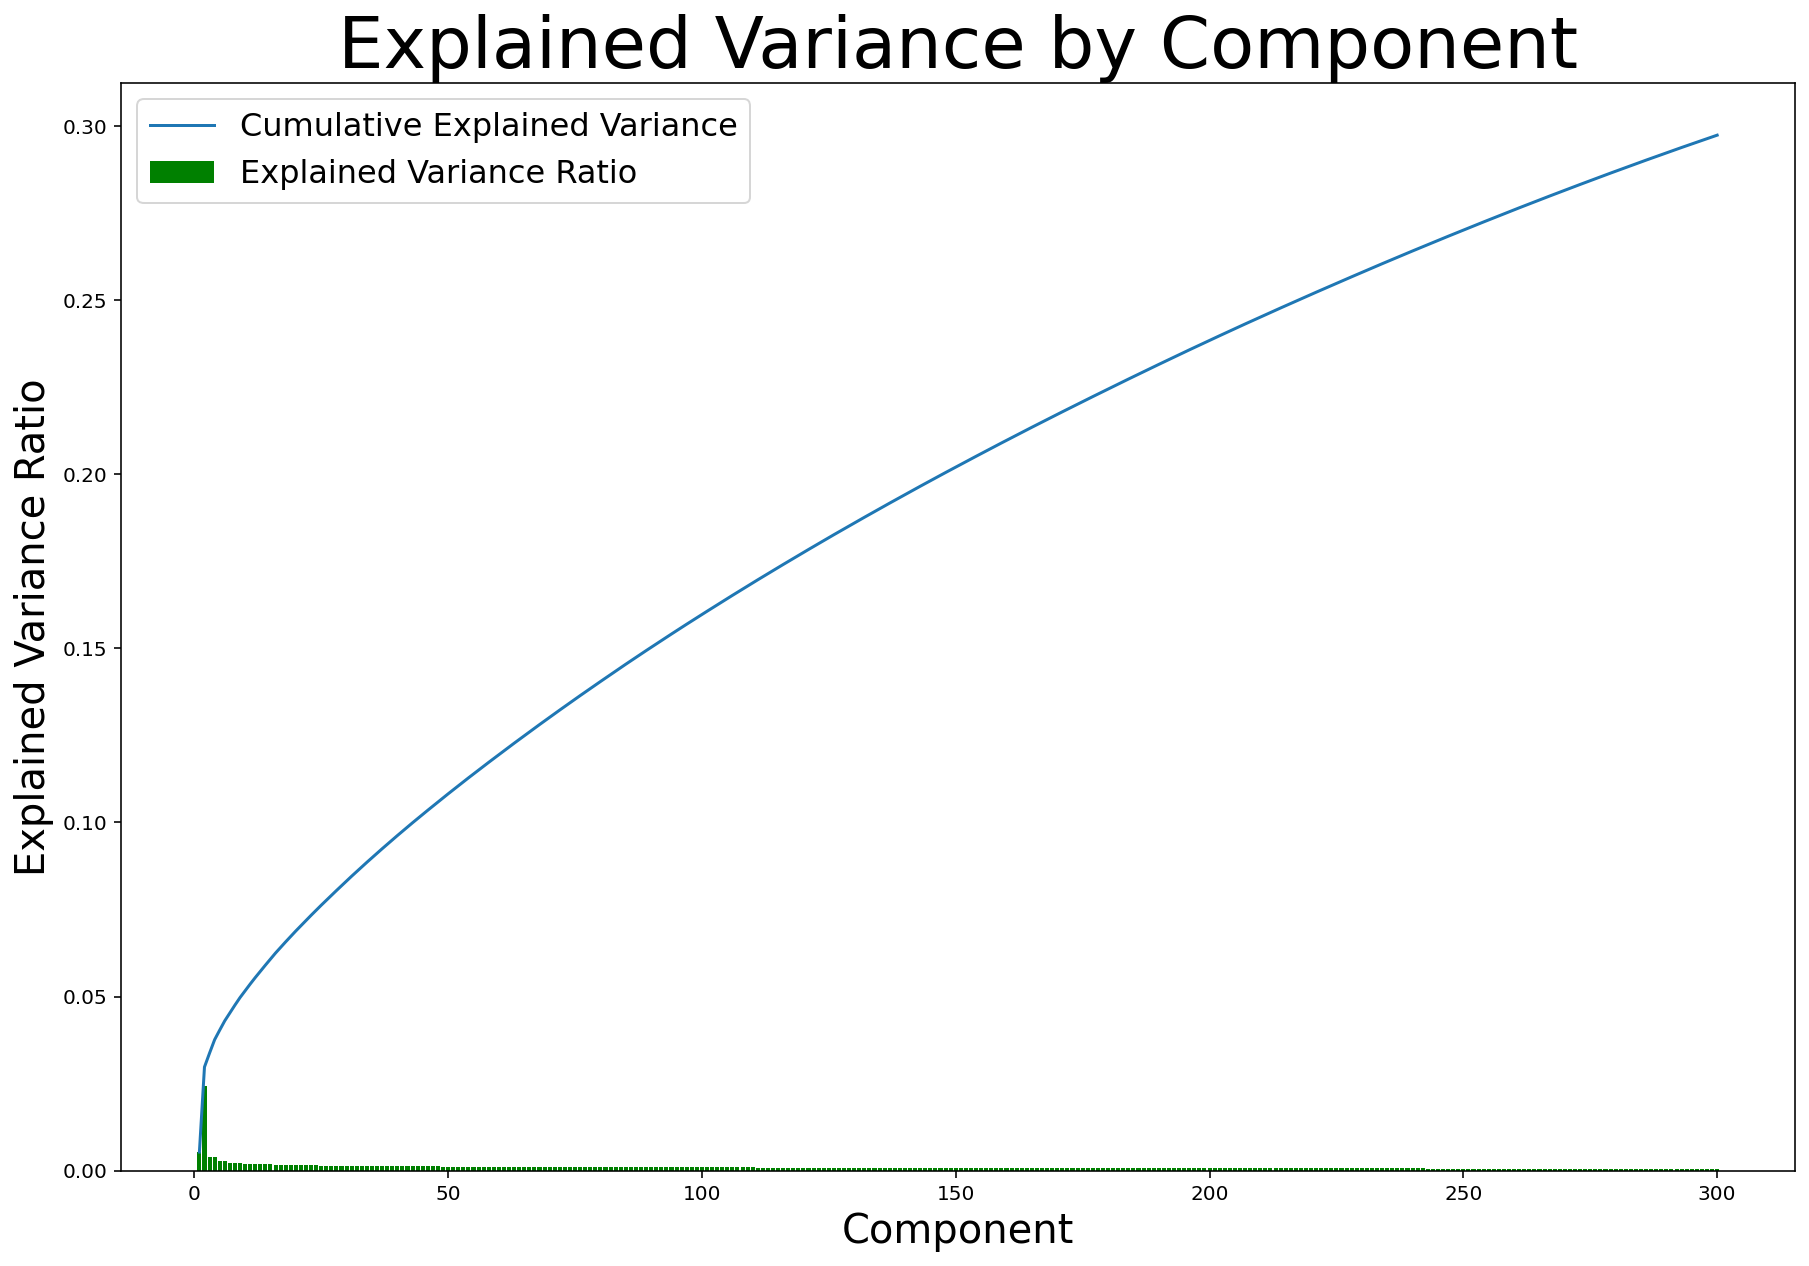

In [12]:
fig = plt.figure(figsize=(15,10))
plt.bar(np.array(range(300))+1, 
        SVD.explained_variance_ratio_, 
        color='g', 
        label='Explained Variance Ratio')
plt.plot(np.array(range(300))+1, 
         np.cumsum(SVD.explained_variance_ratio_), 
         label='Cumulative Explained Variance')
plt.legend(fontsize=16)
plt.xlabel('Component', fontsize=20)
plt.ylabel('Explained Variance Ratio', fontsize=20)
plt.title('Explained Variance by Component', fontsize=36);

As we can see, the ratio of each component's variance explained is miniscule, but cumulatively we have just under 30% of the variance explained by our components.

In [13]:
f'The cumulative explained variance is {round(SVD.explained_variance_ratio_.sum()*100,2)}%'

'The cumulative explained variance is 29.74%'

This is a little less than expected, since 300 components out of 10156 words is roughly a third. This fact ended up being one of the reasons by I decided to stick to a bag-of-words model without using SVD, since there was no efficiency gain in this dimensionality reduction. However, I still want to dabble in topic modeling, so I take a peek at the first few components below to see if any themes emerge.

In [14]:
component_names = ["component_"+str(i+1) for i in range(300)]
svd_df = pd.DataFrame(svd_matrix,
                      columns=component_names)

Here I'm creating a dataframe from our components.

In [15]:
svd_df.shape

(35808, 300)

Now we have a similar dataframe to our original word_df, except instead of one vector for each of our words, we have one for each of our components.

In [16]:
svd_df.head()

,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,component_10,...,component_291,component_292,component_293,component_294,component_295,component_296,component_297,component_298,component_299,component_300
0,0.091711,-0.001442,0.062383,-0.030295,-0.026979,-0.023807,-0.011297,-0.005165,-0.022788,0.024173,...,-0.008568,0.034221,0.007801,-0.036783,-0.008110,0.000943,-0.007308,-0.025032,0.001737,-0.016043
1,0.195037,-0.002919,0.017907,-0.048147,0.023679,0.007208,0.068186,-0.039049,0.116852,0.042106,...,0.015338,-0.027375,0.006627,0.002274,0.083462,0.035731,-0.018404,-0.054973,-0.001402,0.030238
2,0.212215,-0.002992,-0.092846,0.002291,0.074049,-0.026050,0.018302,-0.064586,0.000756,-0.003689,...,-0.021980,0.008084,0.027589,0.036515,-0.001560,0.013915,-0.024442,0.018757,0.018406,0.006036
3,0.172220,-0.002605,-0.066367,-0.049423,0.031487,0.048176,0.006336,0.095473,-0.049652,0.070768,...,-0.011694,-0.000874,0.006311,-0.017019,0.058260,-0.005893,0.018432,-0.024468,-0.043594,-0.052050
4,0.235732,-0.003577,0.007083,-0.025017,0.013481,0.006274,0.010349,0.038009,-0.023675,0.058943,...,-0.004072,0.013890,-0.016084,0.017334,-0.009263,-0.028232,-0.032226,-0.005064,-0.007657,-0.002844


I want to now see which words are loading into these components, as index numbers are not helpful. Below I create a new loadings DataFrame that grabs the words and matches them up with their components. 

In [17]:
loadings = pd.DataFrame(SVD.components_,
                        index=component_names,
                        columns=word_df.columns).T

In [18]:
loadings.shape

(10156, 300)

Simply as a change of pace, instead of showing the usual first 5 rows, as is customary with the .head() method of Pandas DataFrames, I decided to pick an arbitrary 5 rows somewhere in the middle. I also contracted the columns displayed to only the first three, and the last three, to see if the values match up (minus the negative signs).

In [19]:
loadings.iloc[5000:5005, np.r_[0:3, -3:0]]

,component_1,component_2,component_3,component_298,component_299,component_300
joint,0.001076,-0.000019,0.002313,0.000493,-0.000343,0.000155
joints,0.000785,-0.000012,0.001715,0.001790,-0.000678,-0.001517
joke,0.006116,-0.000092,-0.008797,-0.000458,0.000558,0.000941
joked,0.000634,-0.000011,-0.000477,-0.000776,0.000133,-0.000196
jokes,0.003470,-0.000057,-0.006150,0.002304,-0.000958,0.001790


Now I want to see which words are loading the most in my first component, to see if any semblance of a topic emerges. For demonstration purposes, I'm just going to look at the top 10 in terms of magnitude.

In [20]:
loadings.sort_values('component_1',ascending=False).head(10)[['component_1']]

,component_1
feel,0.191970
know,0.165157
really,0.154187
time,0.146398
want,0.126755
things,0.119049
people,0.118218
think,0.114041
going,0.112855
day,0.112231


Component one seems to be regarding the time management issue that I previously touched upon. People with ADHD knowing that there is work to do, and really want to do it, but struggle with managing their time and feel bad for not being able to handle the little, everyday things that other people take for granted. 

In [21]:
loadings.sort_values('component_2',ascending=False).head(10)[['component_2']]

,component_2
deleted,0.999884
post,0.000779
delete,0.000723
comment,0.000646
message,0.000646
account,0.000390
facebook,0.000357
instagram,0.000347
posted,0.000326
media,0.000318


Component 2 seems to be regarding the deletion of social media. In particular, the word `deleted` is accounting for almost 100% of the entire component! Below I plot these two components to see if any discernible relationship between the two exists.

In [22]:
# need to reset the index in order to realign the original dataframe with the new SVD one.
clean_df2 = clean_df.reset_index(drop=True)

# so that then I can create a target variable that will allow me to again segment posts by their respective subreddit
target = clean_df2['ADHD']

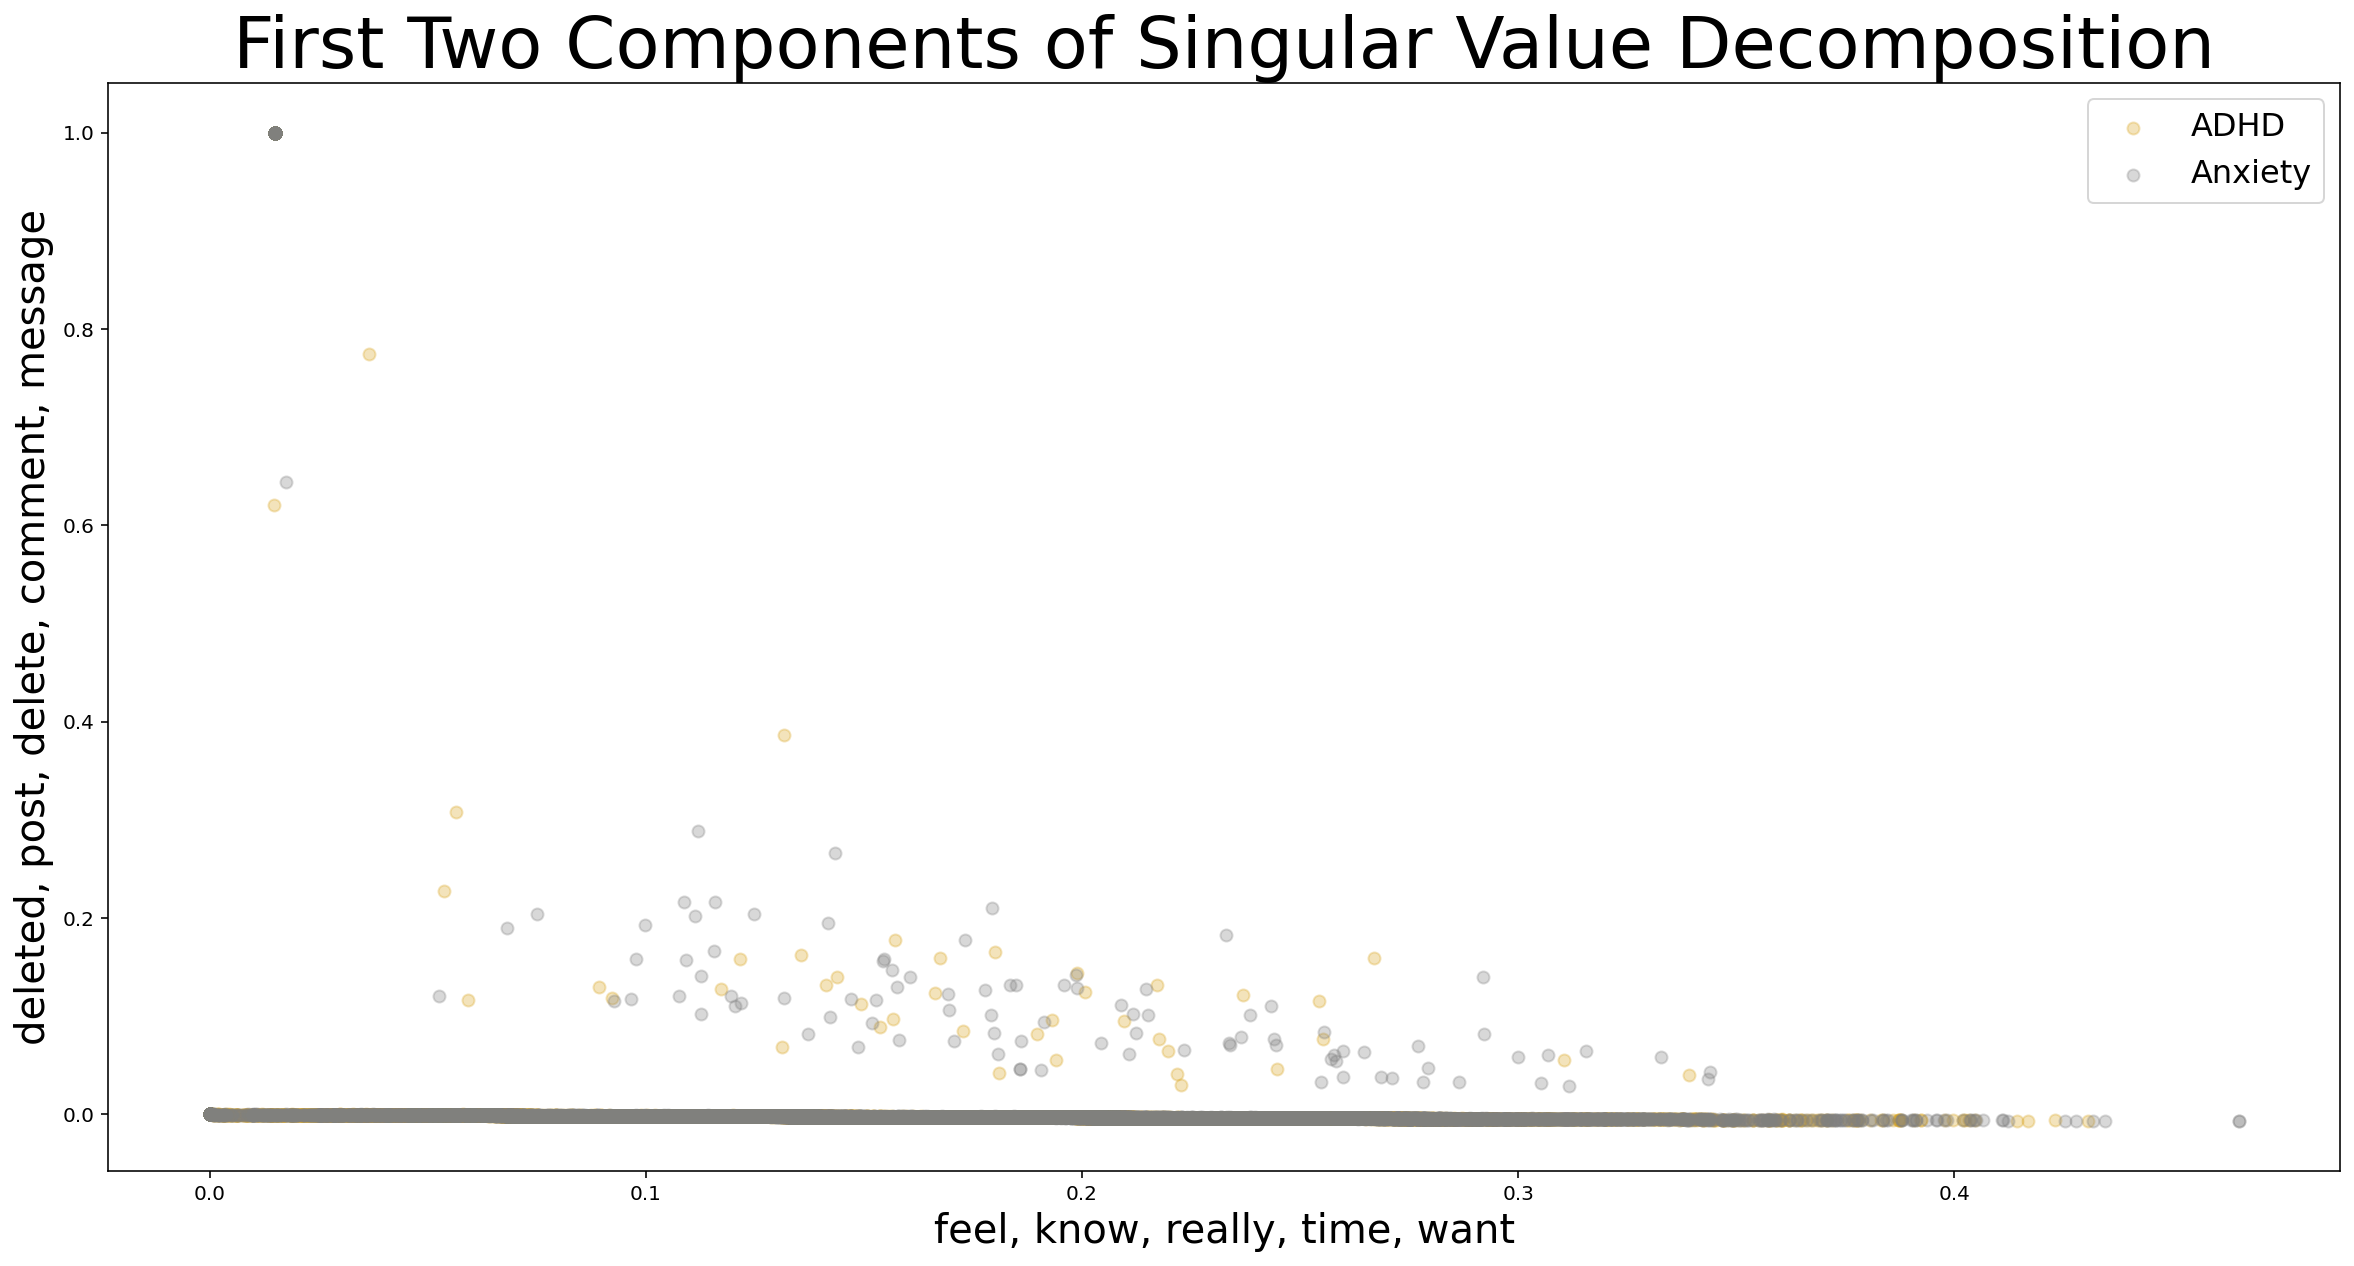

In [23]:
plt.figure(figsize=(20,10))
plt.scatter(svd_df.component_1[target==1], svd_df.component_2[target==1], c='goldenrod', alpha=.3)
plt.scatter(svd_df.component_1[target==0], svd_df.component_2[target==0], c='grey', alpha=.3)
plt.xlabel(f"{', '.join(loadings.sort_values('component_1',ascending=False).head(5)[['component_1']].index)}",
          fontsize=20)
plt.ylabel(f"{', '.join(loadings.sort_values('component_2',ascending=False).head(5)[['component_2']].index)}",
          fontsize=20)
plt.title('First Two Components of Singular Value Decomposition', fontsize=36)
plt.legend(['ADHD', 'Anxiety'], fontsize=16)
plt.savefig('../assets/components_12.png')

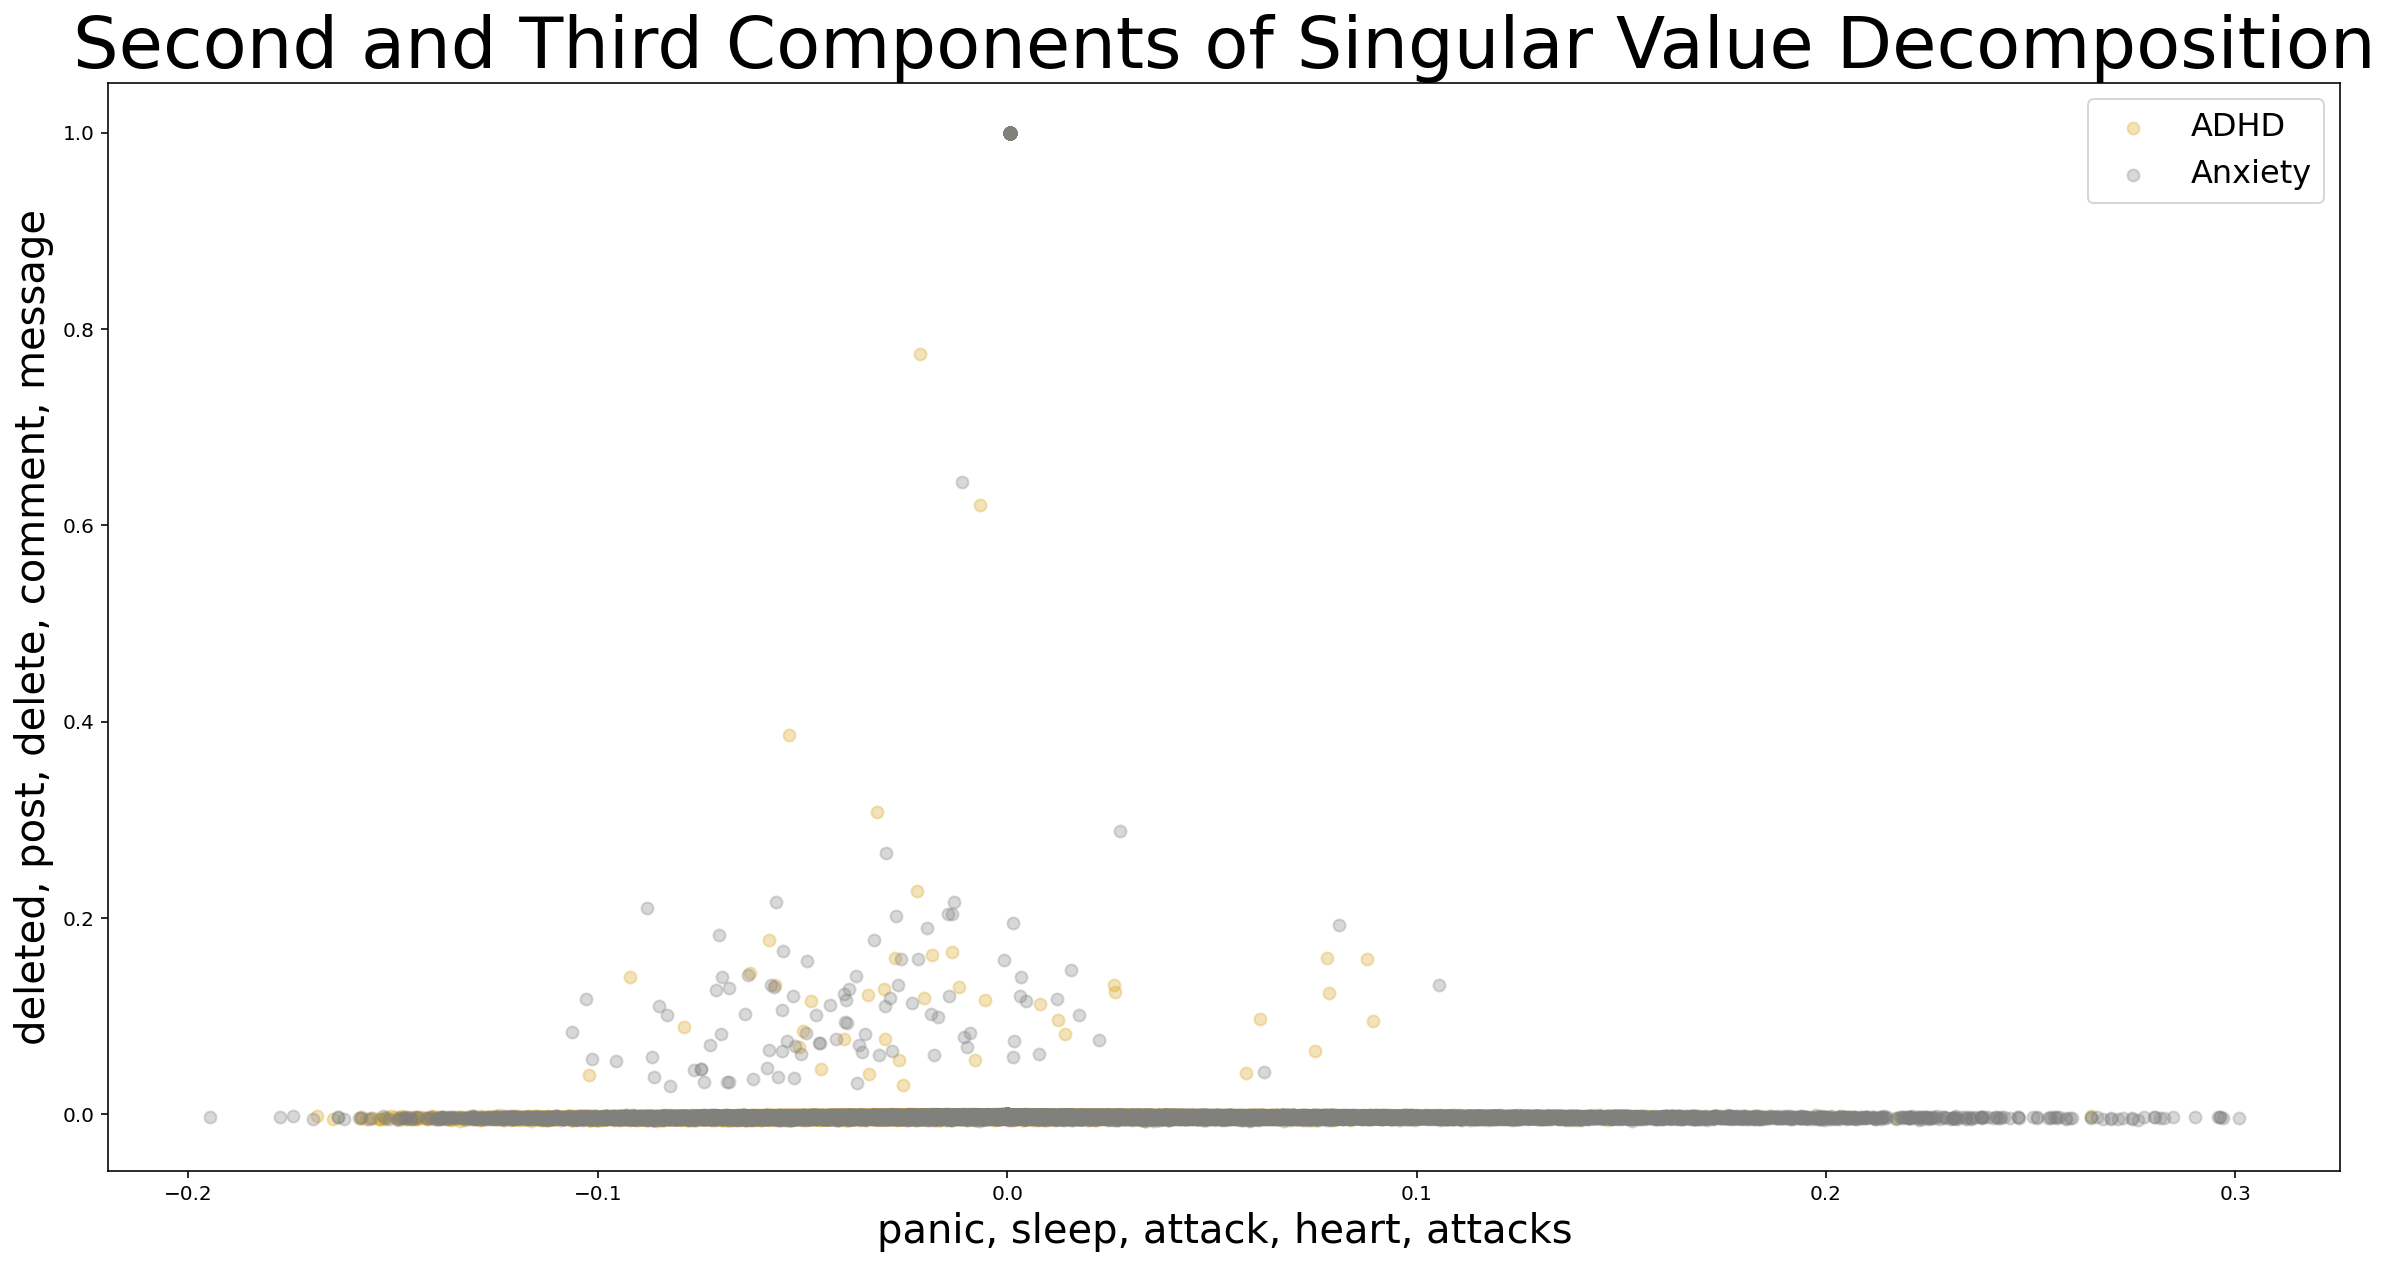

In [24]:
plt.figure(figsize=(20,10))
plt.scatter(svd_df.component_3[target==1], svd_df.component_2[target==1], c='goldenrod', alpha=.3)
plt.scatter(svd_df.component_3[target==0], svd_df.component_2[target==0], c='grey', alpha=.3)
plt.xlabel(f"{', '.join(loadings.sort_values('component_3',ascending=False).head(5)[['component_3']].index)}",
          fontsize=20)
plt.ylabel(f"{', '.join(loadings.sort_values('component_2',ascending=False).head(5)[['component_2']].index)}",
          fontsize=20)
plt.title('Second and Third Components of Singular Value Decomposition', fontsize=36)
plt.legend(['ADHD', 'Anxiety'], fontsize=16)
plt.savefig('../assets/components_23.png')

Here we can see that the word deleted is a huge outlier. No other word comes close to having such a high loading into the component. Thus, the axes labels of the top 5 words loaded in each component is a bit misleading, since the rest of the words account for less than .0001%. As such, most of the values end up as a horizontal line on the x axis. From whatever little variation there is, there isn't a good separation of our subreddits. For the second and third components there seems to be a bit more separation, but there is still a lot of overlap, which is to be expected, since again, component two is so heavily dominated by just one word: deleted. 

However, let's see what the above plots would like between the 1st and 3rd components.

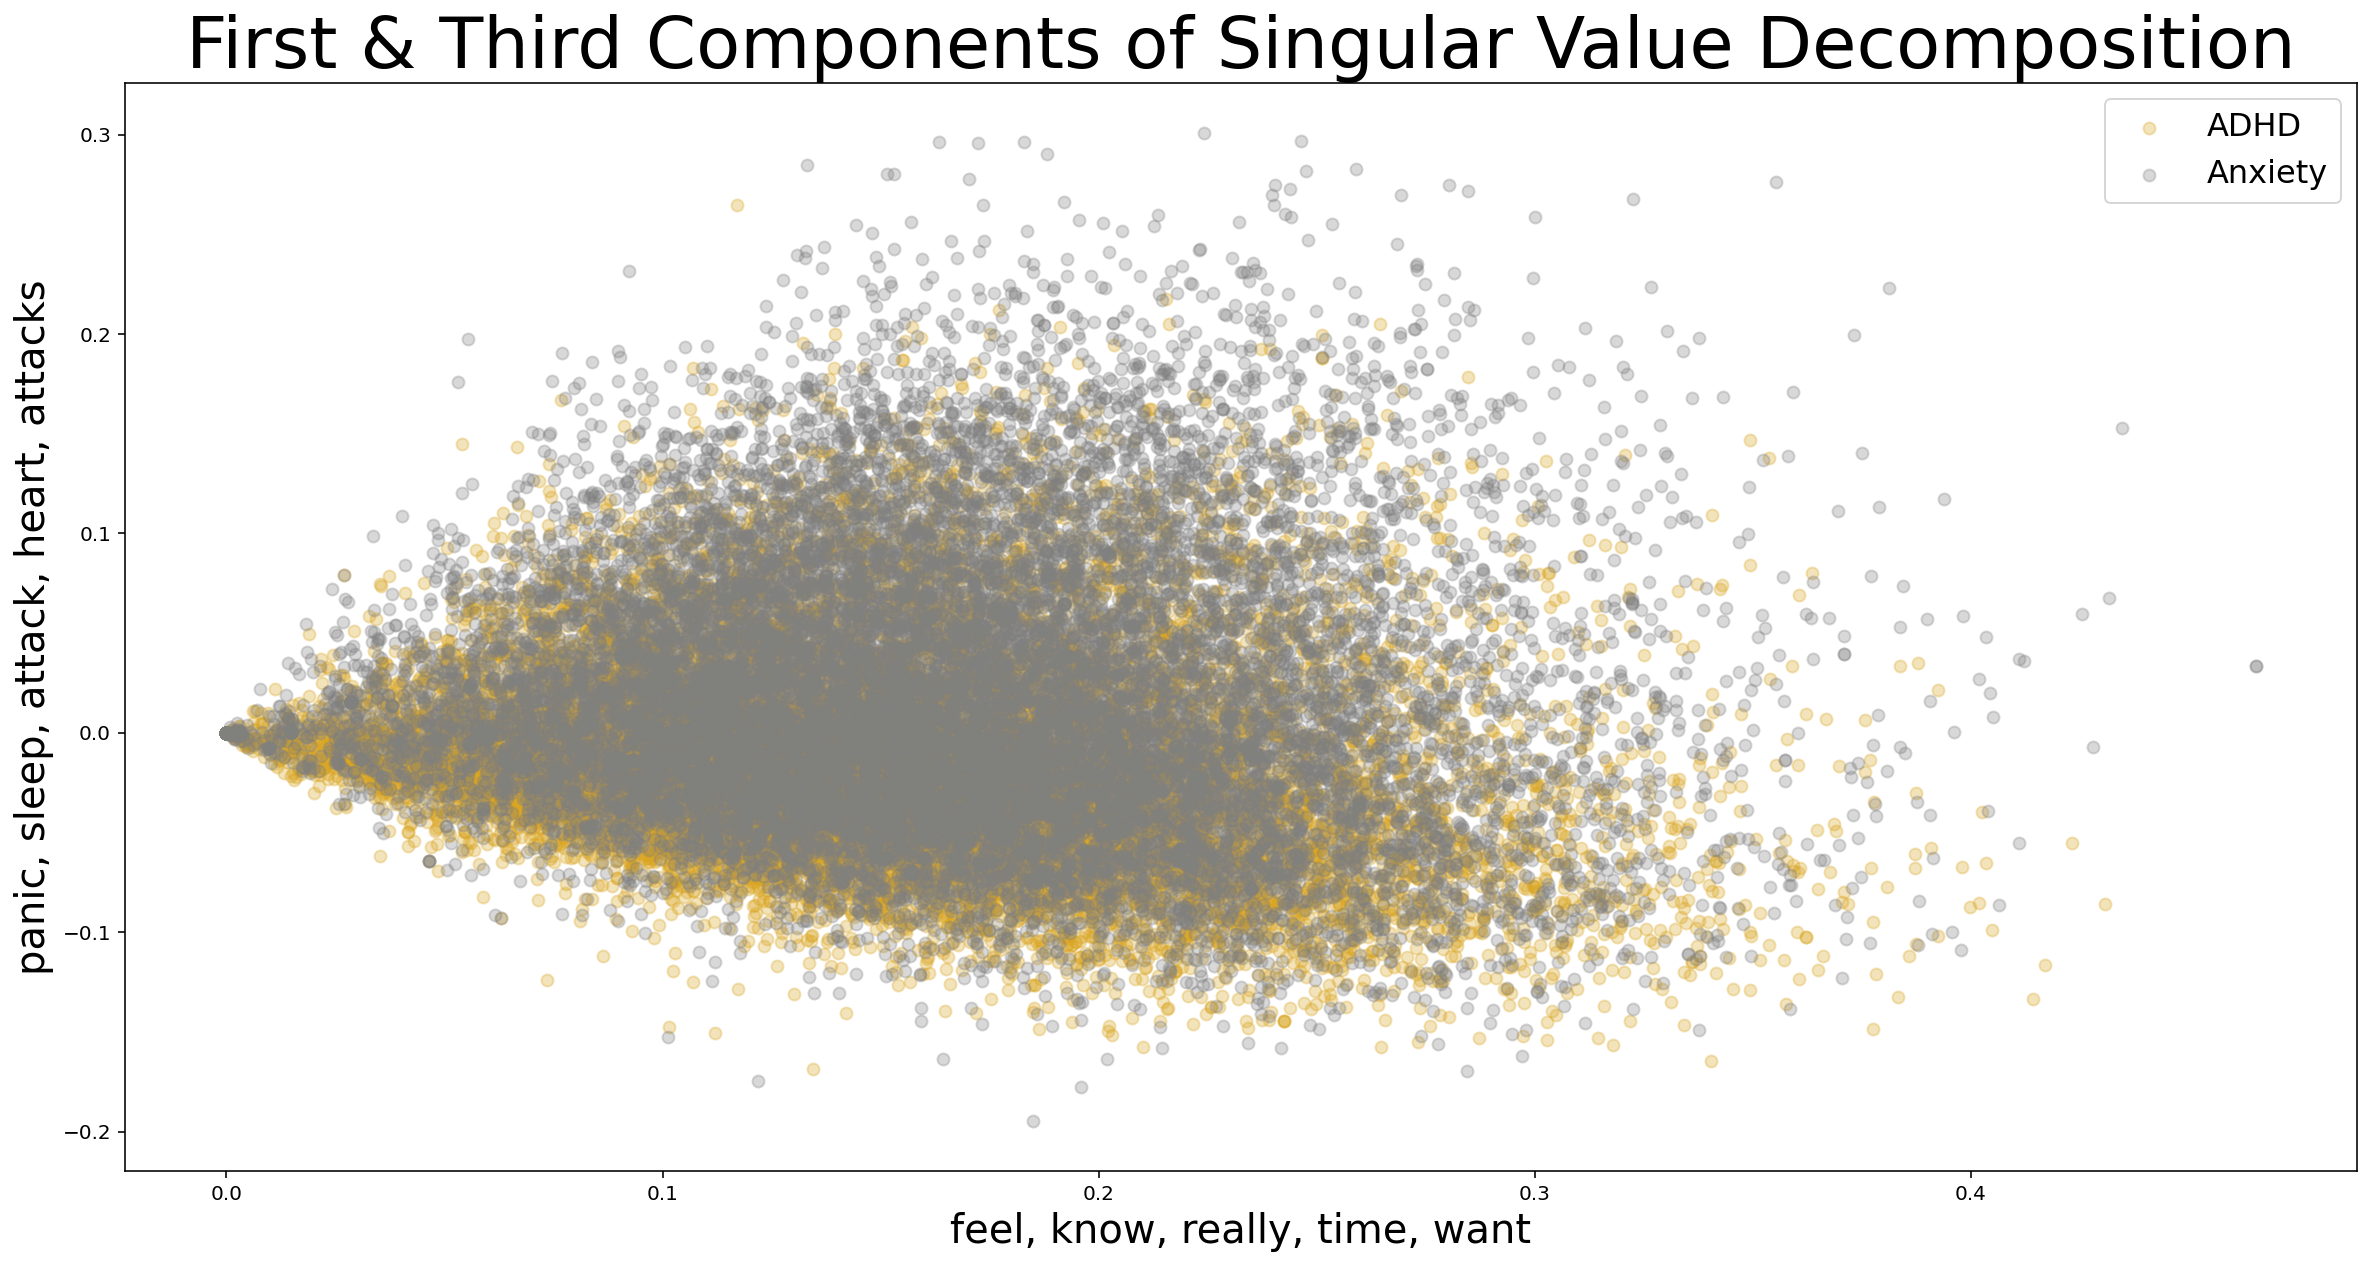

In [25]:
plt.figure(figsize=(20,10))
plt.scatter(svd_df.component_1[target==1], svd_df.component_3[target==1], c='goldenrod', alpha=.3)
plt.scatter(svd_df.component_1[target==0], svd_df.component_3[target==0], c='grey', alpha=.3)
plt.xlabel(f"{', '.join(loadings.sort_values('component_1',ascending=False).head(5)[['component_1']].index)}",
          fontsize=20)
plt.ylabel(f"{', '.join(loadings.sort_values('component_3',ascending=False).head(5)[['component_3']].index)}",
          fontsize=20)
plt.title('First & Third Components of Singular Value Decomposition', fontsize=36)
plt.legend(['ADHD', 'Anxiety'], fontsize=16)
plt.savefig('../assets/components_13.png')

Now we see a much more dispersed plot. Some words load positively into the component, some load negatively, but there is no distinct separation between the 2 subreddits. 

Obviously, there is no way I can replicate this process for all 300 components, so I'm just going to check out the top 10 words for 2 more components, 4 and 5. 

In [26]:
loadings.sort_values('component_4',ascending=False).head(10)[['component_4']]

,component_4
medication,0.225394
meds,0.187628
adderall,0.185574
taking,0.181956
diagnosed,0.161636
vyvanse,0.130953
doctor,0.118461
work,0.115719
prescribed,0.110895
dose,0.107723


Interestingly, component 4 seems to be about medication, specifically ADHD medication, as Adderall and Vyvanse are 2 of the most popular medication prescribed for ADHD. 

In [27]:
loadings.sort_values('component_5',ascending=False).head(10)[['component_5']]

,component_5
sleep,0.283531
work,0.255136
day,0.200134
hours,0.181104
night,0.150612
doing,0.140052
time,0.126370
bed,0.117145
asleep,0.114450
job,0.111030


Component 5 seems to regarding sleep. It is well-documented that ADHD affects sleep and that oftentimes those with ADHD have trouble maintaining "normal" sleep routines, which very often affects their work. 

---

#### Cosine Similarity

Now I'm going to explore some of the most similar posts, using a cosine similarity matrix.

In [24]:
cos_sim_mat = cosine_similarity(svd_matrix, svd_matrix)
cos_sim_mat.shape

(35808, 35808)

In [25]:
np.argsort(cos_sim_mat[1])[:-11:-1]

array([    1, 19682,  4445, 30009, 28687, 16221, 28403,  3455,  9076,
       17123])

In [26]:
np.sort(cos_sim_mat[1])[:-11:-1]

array([1.        , 0.41859538, 0.41727025, 0.39468677, 0.39198307,
       0.38255261, 0.37770335, 0.37359728, 0.3729174 , 0.37137035])

Plugging in these indices back into the original dataframe to see which posts are most similar.

In [27]:
clean_df2.loc[np.argsort(cos_sim_mat[50])[:-11:-1], :]['ADHD']

50       0.0
7627     0.0
16659    0.0
11727    0.0
21452    1.0
27715    1.0
19215    1.0
23032    1.0
35205    1.0
30151    1.0
Name: ADHD, dtype: float64

We can see that 6 of the posts of the top 10 most similar posts are from the ADHD subreddit

In [28]:
clean_df2.loc[np.argsort(cos_sim_mat[50])[:-11:-1], :]['selftext']

50       Sorry if this ends up being kinda long. Also I...
7627     We moved in early together for covid since we ...
16659    I myself suffer from  , which I’ve come to rea...
11727    To preface, I am someone who has moved around ...
21452    I’m just writing this in bed on a Sunday night...
27715    Im a PhD student studying electronics/antennas...
19215    For a little background, I’ve only been offici...
23032    Growing up I always made friends by being crea...
35205    (Not a real book, jus playing)  This may be co...
30151    I usually finish my script before my new one i...
Name: selftext, dtype: object

If we didn't know which posts were from which subreddit, we (humans) might well have a difficult time classifying these posts ourselves. For example, the word diagnosis can apply to both, so it makes sense that it is not a distinguishing feature. In the future I would want to dive deeper into specific conditions of anxiety, social anxiety, or Generalized Anxiety Disorder. 

For now, though, let's save the data we preprocessed so we can access it in the subsequent modeling notebook. For smaller datasets, CSVs are fine, but in this case, saving as CSV would make the svd_df over 226 MBs! Pickling has none of the overhead in terms of encoding and uses various compression techniques, which only makes it 80 MBs. For our full word_df, it's even worse: CSV would be over 1.4 GBs, whereas the pickled file is only 22 MBs!

In [116]:
svd_df.to_pickle('../data/svd_df.gzde', compression='gzip')

In [115]:
word_df.to_pickle('../data/word_df.gzde', compression='gzip')

In [117]:
target.to_pickle('../data/target.gzde', compression='gzip')